In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import PreProcessor, DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare 2 predictions
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data
- First the features are computed (previous daily/weekly/monthly volatility)
- Then the data seperated into training and validation data 

In [37]:
# fetch data through yahoo finance API, compute features, split into training and validation subsets
# ... for both NN and HAR
data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(stock = "IBM", train_size=.6)

### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [38]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list = ([], [2,])
lr_list = (5e-3, 1e-2, 5e-2)
epochs_list = (3, 6, 10)
total_model_options = len(hidden_layers_list) * len(lr_list) * len(epochs_list)

# for all possible models, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            counter += 1
            print(f"Currently at model: {counter} / {total_model_options}", end="\r")
            
            # fit and evaluate model through cross validation
            score_nn = kfolds_fit_and_evaluate_model(
                model = ForwardNeuralNetwork(data_nn_train.x_t.shape[1], output_size = 1, hidden_layers = hidden_layers),
                kfold = TimeSeriesSplit(n_splits = 10, max_train_size = 5000),
                data = data_nn_train,
                lr = lr, 
                epochs = epochs, 
                earlystopper = None,#EarlyStopper(patience=3, min_delta=0),
                normalize_features = False
            )
            
            # store the models performance in array
            model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation beneath
epochs, hidden_layers, lr = df_scores.values[0][1:]
epochs = int(epochs)

   avg_score  epochs hidden_nodes     lr
0   0.000001       3          [2]  0.010
1   0.000001       3          [2]  0.050
2   0.000001       6          [2]  0.050
3   0.000001       6           []  0.005
4   0.000001      10           []  0.005
5   0.000001       3          [2]  0.005
6   0.000001       6           []  0.010
7   0.000001       3           []  0.010
8   0.000001       6           []  0.050
9   0.000001      10           []  0.010


### Fit and Compare the Final Neural Network Against the HAR Model

No params from cross validation, using own params instead
Or specifically specified to use own params
HAR out-of-sample loss: 9.87885357098115e-07


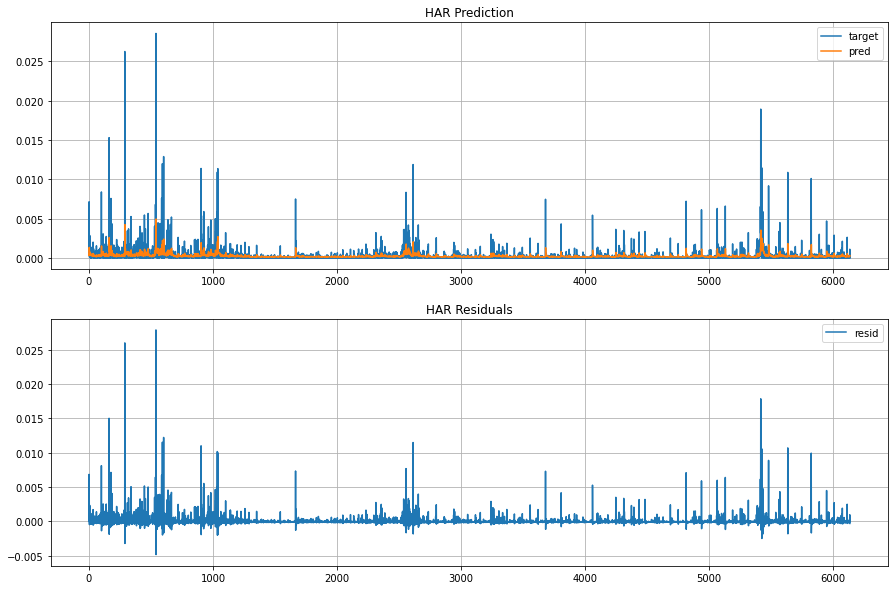

Estimating NN model ...
NN out-of-sample loss: 1.0088493809234933e-06


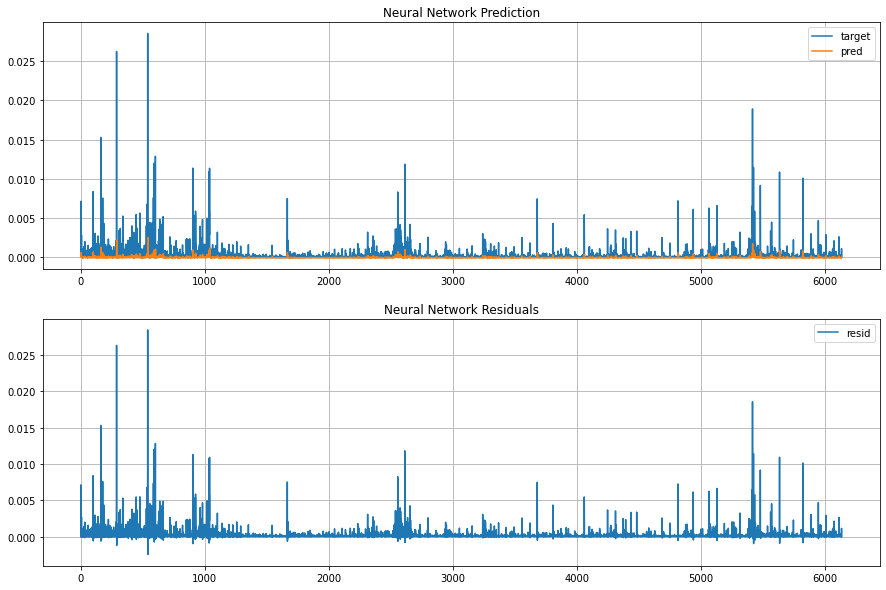

In [74]:
plot = True # plot for both models the true volatility versus the predicted one
normalize_features = False
use_own_config = True

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config: raise Exception()
except:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = 10
    hidden_layers = [2,] # zero or one with 2 nodes
    lr = .005

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    data_train = data_har_train,
    data_test = data_har_val,
    normalize_features = False
)
har_output = output

print(f"HAR out-of-sample loss: {loss}")

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(data_har_val.y, label = "target")
    axs[0].plot(output, label = "pred")
    axs[1].plot(data_har_val.y.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")

NN = ForwardNeuralNetwork(data_nn_train.x_t.shape[1], output_size = 1, hidden_layers=hidden_layers)
loss, output = single_fit_and_evaluate_model(
    NN,
    data_train = data_nn_train,
    data_test = data_nn_val,
    lr = lr,
    epochs = epochs,
    earlystopper = None,
    normalize_features = False,
    return_prediction = True
)
nn_output =  output.detach().numpy().reshape(-1,)

print(f"NN out-of-sample loss: {loss}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network Prediction")
    axs[1].set_title("Neural Network Residuals")
    axs[0].plot(data_nn_val.y_t.detach().numpy().reshape(-1,1), label = "target")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[1].plot(data_nn_val.y_t.detach().numpy().reshape(-1,1) - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

In [45]:
#=========================================================================================
#====================================DIEBOLD-MARIANO======================================
#=========================================================================================
dm_test(data_har_val.y.reshape(-1,), har_output, nn_output, one_sided=True)

(-10.156118324262188, 2.408714850049281e-24)

In [76]:
for name, param in NN.named_parameters():
    if param.requires_grad:
        print(name, param.data[0])

layers.0.weight tensor([ 0.7826,  0.4541, -0.4292])
layers.0.bias tensor(0.0873)
layers.2.weight tensor([ 0.3034, -0.2983])
layers.2.bias tensor(-0.0062)


In [32]:
range_of_input = torch.tensor()

ForwardNeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [48]:
import matplotlib.pyplot as plt

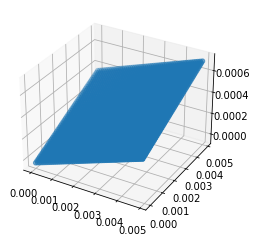

In [77]:

X = np.arange(0, 0.005, .0001)
Y = np.arange(0, 0.005, .0001)

features = np.zeros((len(X)*len(Y), 3))
i = 0
for Xi in X:
    for Yi in Y:
        features[i] = (Xi, Yi, 0)
        i += 1
X = torch.tensor(features, dtype=torch.float32)

Y = NN(X).detach().numpy().reshape(-1,)
X = X.detach().numpy()
ax = plt.figure().add_subplot(projection='3d')

X, Y, Z = X[:,0], X[:, 1], Y
ax.scatter(X, Y, Z)
# ax.plot_surface(X, Y, Z.reshape(-1,1))

